
# Download the Unsplash dataset (photos) and Create the RAMP Dataset

This notebook is used to download all images from the Unsplash dataset: https://github.com/unsplash/datasets. version Lite (25000 images) 


In [1]:
from pathlib import Path

unsplash_dataset_path = Path("unsplash-research-dataset-lite-latest")

## Load the dataset

The `photos.tsv000` contains metadata about the photos in the dataset, but not the photos themselves. We will use the URLs of the photos to download the actual images.

In [2]:
import pandas as pd

# Read the photos table
photos = pd.read_csv(unsplash_dataset_path / "photos.tsv000", sep='\t', header=0)

# Extract the IDs and the URLs of the photos
photo_urls = photos[['photo_id', 'photo_image_url']].values.tolist()

# Print some statistics
print(f'Photos in the dataset: {len(photo_urls)}')

Photos in the dataset: 25000


The file name of each photo corresponds to its unique ID from Unsplash. We will download the photos in a reduced resolution (640 pixels width), because they are downscaled by CLIP anyway.

CREATE THE "photos" DIRECTORY BEFORE LAUNCHING (must be created in the depository 'unsplash-research-dataset-lite-latest')

In [3]:
import urllib.request

# Path where the photos will be downloaded

photos_donwload_path = unsplash_dataset_path / "photos"

# Function that downloads a single photo
def download_photo(photo):
    # Get the ID of the photo
    photo_id = photo[0]

    # Get the URL of the photo (setting the width to 640 pixels)
    photo_url = photo[1] + "?w=640"

    # Path where the photo will be stored
    photo_path = photos_donwload_path / (photo_id + ".jpg")

    # Only download a photo if it doesn't exist
    if not photo_path.exists():
        try:
            urllib.request.urlretrieve(photo_url, photo_path)
        except:
            # Catch the exception if the download fails for some reason
            print(f"Cannot download {photo_url}")
            pass

Now the actual download! The download can be parallelized very well, so we will use a thread pool. You may need to tune the `threads_count` parameter to achieve the optimzal performance based on your Internet connection. For me even 128 worked quite well.

Uncomment to launch

In [4]:
from multiprocessing.pool import ThreadPool

# # Create the thread pool
# threads_count = 16
# pool = ThreadPool(threads_count)

# # Start the download
# pool.map(download_photo, photo_urls)

# # Display some statistics
# display(f'Photos downloaded: {len(photos)}')

Actually, we have 24978 photos

# Image transformation
Let's analyze one image and how we will compress it

(800, 640, 3)


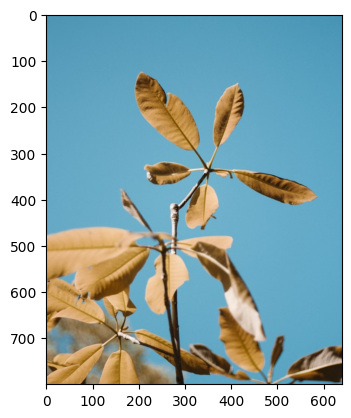

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread(photos_donwload_path / '__1Mu7EZXOM.jpg')
imgplot = plt.imshow(img)
print(img.shape)

In [12]:
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import numpy as np

def resize_image(img, image_size = (320, 320), verbose=False):
    """
    Resize original image to ensure its shape is a multiple of size_factor in each spatial dimension
    Reduce/adapt to image_size and convert to Black & White
    """
    image = color.rgb2gray(img) # convert gray
    image_resized = resize(image, (image_size), anti_aliasing=True)

    return image_resized

In [6]:
from skimage.measure import block_reduce

def transform_image(img, size_factor=5):
    """
    Reduce resolution of image by a size factor
    Returns an image of lower size than the original one
    
    Parameters
    ----------
    size_factor: factor resolution change (size_factor = 2, resolution will be divided by 2 in each spatial dimension)
    Returns
    -------
    An image of the spatial dimension of the input image divided by size_factor (no channel)
    """
    image_downscaled = downscale_local_mean(img, (size_factor, size_factor))
    
    return image_downscaled

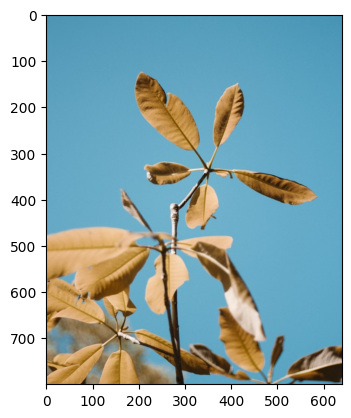

In [7]:
imgplot = plt.imshow(img)

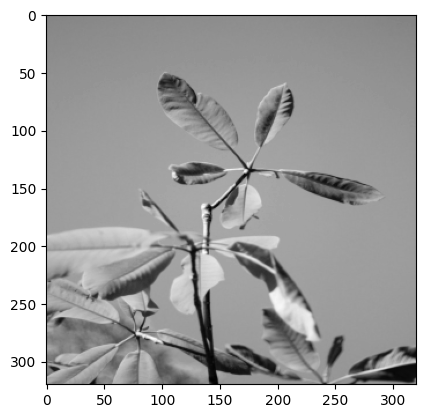

In [8]:
size_factor = 5
img_resized = resize_image(img)
imgplot = plt.imshow(img_resized, cmap='gray')

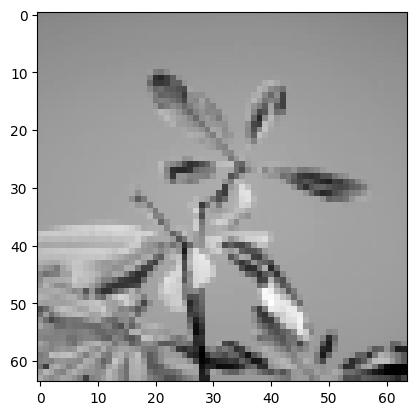

In [9]:
size_factor = 5
img_resized = resize_image(img)
img_down = transform_image(img_resized, size_factor=size_factor)
# print(img_down[:10, 100, 1])
imgplot = plt.imshow(img_down, cmap='gray')

Here is a way to come back to the initial image format (full resolution and RGB format, actually we only duplicate onto 3 channels)

In [22]:
import scipy.ndimage

img_size = (320, 320)

img_reconstructed = scipy.ndimage.zoom(img_down * 255, (size_factor, size_factor), order=3).astype(np.uint8) / 255

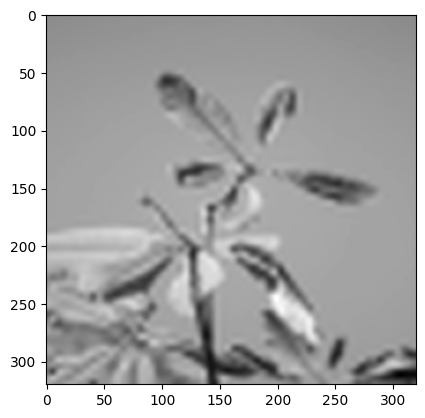

In [23]:
plt.imshow(img_reconstructed, cmap='gray')

In [33]:
img_random = np.random.randint(0, 255, size=img_resized.shape) / 255
rmse_resized = np.sqrt(np.sum((img_resized - img_resized)**2) / img_resized.size)
rmse_reconstructed = np.sqrt(np.sum((img_reconstructed - img_resized)**2) / img_resized.size)
rmse_random = np.sqrt(np.sum((img_random - img_resized)**2) / img_resized.size)
print("rmse original (sanity check): ", rmse_resized)
print("rmse reconstructed image: ", rmse_reconstructed)
print("rmse random image: ", rmse_random)

rmse original (sanity check):  0.0
rmse reconstructed image:  0.05508625427678969
rmse random image:  0.32247641313323405


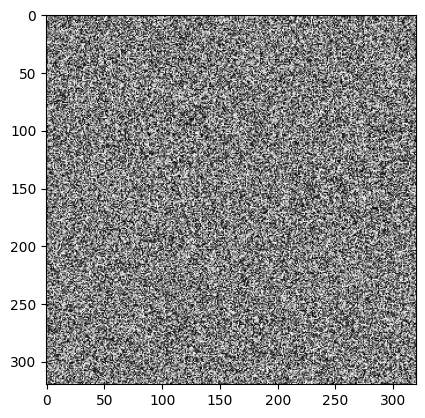

In [34]:
plt.imshow(img_random, cmap='gray')

# Dataset creation

Create the "Dataset" depository before launching (in the same depository as this notebook)

In [11]:
import glob
from PIL import Image
from pathlib import Path
from tqdm import tqdm
photos_path = Path("unsplash-research-dataset-lite-latest") / "photos"
pathlist = Path(photos_path).glob('**/*.jpg')
max_h = 0
max_w = 0
for path in tqdm(pathlist):
    img = mpimg.imread(path)
    max_h = np.maximum(img.shape[0], max_h)
    max_w = np.maximum(img.shape[1], max_w)

print(max_h, max_w)

24977it [01:53, 220.49it/s]

1896 640


In [43]:
import glob
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from copy import deepcopy

# pictures generating error : YRJrO0-OP1A.jpg , UsWjYe1FdlU.jpg cut manually
# Number of pictures in each dataset
n_public_train = 5000
n_public_test = 1000
n_private_train = 5000
n_private_test = 1000


photos_path = Path("unsplash-research-dataset-lite-latest") / "photos"
save_path_str = "Dataset/public/Train/"

counter = 0
size_factor = 5

pathlist = Path(photos_path).glob('**/*.jpg')
for path in tqdm(pathlist):
    # print(path)
    img_in = resize_image(mpimg.imread(path)) # Resize original image
    img_out = transform_image(img_in, size_factor = size_factor) # generate low resolution b&w image
    # print(img_in.shape)
    # print(img_out.shape)
    img_in_filename = save_path_str + "H" + str(format(counter, '05d')) + "_hi.jpg"
    img_out_filename = save_path_str + "L" + str(format(counter, '05d')) + "_lo.jpg"
    # print(img_in.dtype)
    # print(img_out.dtype)
    mpimg.imsave(img_in_filename, img_in, cmap='gray', dpi=72)
    mpimg.imsave(img_out_filename, img_out, cmap='gray', dpi=72)
    # plt.imshow(img)

    counter += 1
    if counter == n_public_train:
        save_path_str = "Dataset/public/Test/"
    elif counter == n_public_train + n_public_test:
        save_path_str = "Dataset/private/Train/"
    elif counter == n_public_train + n_public_test + n_private_train:
        save_path_str = "Dataset/private/Test/"
    elif counter == n_public_train + n_public_test + n_private_train + n_private_test:
        break
    elif counter >= 25000:
        break



11999it [02:55, 68.33it/s]


Create numpy arrays for each dataset

In [44]:
import os
def _get_data(path="./Dataset", set = 'public', split='Train'):
    assert split in ['Train', 'Test'], 'split must be either Train or Test'
    assert set in ['public', 'private'], 'set must be either public or private'
    path = os.path.join(path, set, split)
    photos_path = Path(path)
    file_list = os.listdir(photos_path)
    counter = 0
    data_x = []
    data_y = []
    for f in file_list:  # iterate through the files
        fpath = os.path.join(photos_path, f)
        fpath = fpath.replace('\\', '/')
        fpath = fpath.replace('._', '')
        if fpath.endswith('_hi.jpg'):
            # get the high resolution image
            img = mpimg.imread(fpath)
            data_y.append(img)
            # get the corresponding low resolution image
            fpath = fpath.replace('_hi.jpg', '_lo.jpg')
            fpath = fpath.replace('H', 'L')
            img = mpimg.imread(fpath)
            data_x.append(img)
        counter += 1
        if counter >= 25000:
            break
    return data_x, data_y

In [48]:
x_train_public, y_train_public = _get_data(set ='public', split = 'Train') 
x_test_public, y_test_public = _get_data(set ='public', split = 'Test') 
x_train_private, y_train_private = _get_data(set ='private', split = 'Train') 
x_test_private, y_test_private = _get_data(set ='private', split = 'Test') 

In [66]:
## convert the data to tensors
import torch
X_train_public_tensor = [torch.from_numpy(x) for x in tqdm(x_train_public)]
Y_train_public_tensor = [torch.from_numpy(x) for x in tqdm(y_train_public)]
X_test_public_tensor = [torch.from_numpy(x) for x in tqdm(x_test_public)]
Y_test_public_tensor = [torch.from_numpy(x) for x in tqdm(y_test_public)]
X_train_private_tensor = [torch.from_numpy(x) for x in tqdm(x_train_private)]
Y_train_private_tensor = [torch.from_numpy(x) for x in tqdm(y_train_private)]
X_test_private_tensor = [torch.from_numpy(x) for x in tqdm(x_test_private)]
Y_test_private_tensor = [torch.from_numpy(x) for x in tqdm(y_test_private)]

100%|██████████| 1000/1000 [00:00<00:00, 843076.18it/s]


In [67]:
from torch.utils.data import DataLoader, Dataset

## We now define a customized dataset class

class Dataset_custom(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

In [68]:
train_public_dataset = Dataset_custom(X_train_public_tensor, Y_train_public_tensor)
test_public_dataset = Dataset_custom(X_test_public_tensor, Y_test_public_tensor)
train_private_dataset = Dataset_custom(X_train_private_tensor, Y_train_private_tensor)
test_private_dataset = Dataset_custom(X_test_private_tensor, Y_test_private_tensor)

In [69]:
X_train_public = [item[0].numpy() for item in tqdm(train_public_dataset)]
Y_train_public = [item[1].numpy() for item in tqdm(train_public_dataset)]
X_test_public = [item[0].numpy() for item in tqdm(test_public_dataset)]
Y_test_public = [item[1].numpy() for item in tqdm(test_public_dataset)]

100%|██████████| 1000/1000 [00:00<00:00, 636464.95it/s]


In [70]:
X_train_private = [item[0].numpy() for item in tqdm(train_private_dataset)]
Y_train_private = [item[1].numpy() for item in tqdm(train_private_dataset)]
X_test_private = [item[0].numpy() for item in tqdm(test_private_dataset)]
Y_test_private = [item[1].numpy() for item in tqdm(test_private_dataset)]

100%|██████████| 1000/1000 [00:00<00:00, 819680.28it/s]


In [71]:
X_train_public = np.stack(X_train_public, axis=0)
Y_train_public = np.stack(Y_train_public, axis=0)
X_train_public.shape, Y_train_public.shape

((5000, 64, 64, 3), (5000, 320, 320, 3))

In [72]:
X_test_public = np.stack(X_test_public, axis=0)
Y_test_public = np.stack(Y_test_public, axis=0)
X_test_public.shape, Y_test_public.shape

((1000, 64, 64, 3), (1000, 320, 320, 3))

In [73]:
X_train_private = np.stack(X_train_private, axis=0)
Y_train_private = np.stack(Y_train_private, axis=0)
X_train_private.shape, Y_train_private.shape

((5000, 64, 64, 3), (5000, 320, 320, 3))

In [74]:
X_test_private = np.stack(X_test_private, axis=0)
Y_test_private = np.stack(Y_test_private, axis=0)
X_test_private.shape, Y_test_private.shape

((1000, 64, 64, 3), (1000, 320, 320, 3))

Save data

In [75]:

if not os.path.exists('data'):
    os.makedirs('data')
    os.makedirs('data/public')

In [76]:
np.save('data/Xtrain.npy', X_train_private)
np.save('data/Ytrain.npy', Y_train_private)
np.save('data/Xtest.npy', X_test_private)
np.save('data/Ytest.npy', Y_test_private)
np.save('data/public/Xtrain.npy', X_train_public)
np.save('data/public/Ytrain.npy', Y_train_public)
np.save('data/public/Xtest.npy', X_test_public)
np.save('data/public/Ytest.npy', Y_test_public)